In [3]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx as ox # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
from shapely.geometry import Polygon
import numpy as np
import pandana as pdna
import os
from tqdm import tqdm

In [5]:
#amenities_with_neighborhood.to_file("amenities_with_neighborhood.geojson", driver='GeoJSON')
amenities_with_neighborhood = gpd.read_file('/Users/emmastoklundlee/Documents/Social Data Science - Masters/Semester Four/Geospatial Data Science/GDS_project/dataframes/amenities_with_neighborhood.geojson')

In [17]:
neighbourhoods = list(amenities_with_neighborhood['Arrondissement'].unique())[:-1]
neighbourhoods = [neighborhood + ', Montreal, Canada' for neighborhood in neighbourhoods]

In [18]:
# Define the string to be replaced and its replacement
old_string = "L'Île-Bizard–Sainte-Geneviève / Pierrefonds-Roxboro, Montreal, Canada"
new_string = "L'Île-Bizard–Sainte-Geneviève, Montreal, Canada"

# Iterate through the list and replace the old string with the new one
for i, neighborhood in enumerate(neighbourhoods):
    if neighborhood == old_string:
        neighbourhoods[i] = new_string

print(neighbourhoods)


['Ahuntsic-Cartierville, Montreal, Canada', 'Verdun, Montreal, Canada', 'Ville-Marie, Montreal, Canada', 'Le Plateau-Mont-Royal, Montreal, Canada', 'Outremont, Montreal, Canada', 'Rosemont–La Petite-Patrie, Montreal, Canada', 'Villeray–Saint-Michel–Parc-Extension, Montreal, Canada', 'Mercier–Hochelaga-Maisonneuve, Montreal, Canada', 'Le Sud-Ouest, Montreal, Canada', 'Anjou, Montreal, Canada', 'Saint-Léonard, Montreal, Canada', 'Côte-des-Neiges–Notre-Dame-de-Grâce, Montreal, Canada', 'Saint-Laurent, Montreal, Canada', 'Rivière-des-Prairies–Pointe-aux-Trembles, Montreal, Canada', "L'Île-Bizard–Sainte-Geneviève, Montreal, Canada", 'LaSalle, Montreal, Canada', 'Lachine, Montreal, Canada', 'Montréal-Nord, Montreal, Canada']


In [46]:
#amenities_of_interest = ['restaurant', 'cafe', 'school']
place = 'Montreal, Canada'
type_of_transportation = 'walk'
#tags = {'amenity': amenities_of_interest}
#tags = {'shop': ['grocery', 'greengrocer', 'supermarket']}
tags = {'amenity':'school'}
walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

In [47]:
amenities = ox.geometries_from_place(place, tags=tags)
amenities = amenities.to_crs('EPSG:25832')
# Some amenities might be polygons, but we need them as points, so let's extract the centroids from the amenities' geometries
centroids = amenities.centroid

/var/folders/3m/k0nn68mj0ylfjxzs4mcl9_f00000gn/T/ipykernel_5714/31444245.py:1: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  amenities = ox.geometries_from_place(place, tags=tags)


In [1]:
# RUN ONLY ONCE TO SAVE THE GRAPHS - ALREADY DONE

graphs = {}

# specify parameters for the analysis
walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

# Loop through the neighborhoods
for neighborhood in tqdm(neighbourhoods):
    # Create a graph for the current neighborhood
    G_walk_neighborhood = ox.graph_from_place(neighborhood, network_type='walk') # type of transportation is set here

    for u, v, data in G_walk_neighborhood.edges(data=True):
        data['speed_kph'] = walk_speed
    G_walk_neighborhood = ox.add_edge_travel_times(G_walk_neighborhood) # this computes the travel time in seconds based on the 'speed_kph' column

# caro path
    # ox.save_graphml(G_walk_neighborhood, f"/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood
# michel path
    ox.save_graphml(G_walk_neighborhood, f"../graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood
    # Store the graph in the dictionary using the neighborhood name as the key
    graphs[neighborhood] = G_walk_neighborhood

In [10]:
# rename "L'Île-Bizard–Sainte-Geneviève / Pierrefonds-Roxboro, Montreal, Canada" to "L'Île-Bizard–Sainte-Geneviève, Montreal, Canada" in neighborhoods list
neighbourhoods[0] = "L'Île-Bizard–Sainte-Geneviève, Montreal, Canada"

In [12]:
# remove "L'Île-Bizard–Sainte-Geneviève / Pierrefonds-Roxboro, Montreal, Canada" from neighborhoods list
neighbourhoods = neighbourhoods[1:]

In [19]:
neighbourhoods

['Ahuntsic-Cartierville, Montreal, Canada',
 'Verdun, Montreal, Canada',
 'Ville-Marie, Montreal, Canada',
 'Le Plateau-Mont-Royal, Montreal, Canada',
 'Outremont, Montreal, Canada',
 'Rosemont–La Petite-Patrie, Montreal, Canada',
 'Villeray–Saint-Michel–Parc-Extension, Montreal, Canada',
 'Mercier–Hochelaga-Maisonneuve, Montreal, Canada',
 'Le Sud-Ouest, Montreal, Canada',
 'Anjou, Montreal, Canada',
 'Saint-Léonard, Montreal, Canada',
 'Côte-des-Neiges–Notre-Dame-de-Grâce, Montreal, Canada',
 'Saint-Laurent, Montreal, Canada',
 'Rivière-des-Prairies–Pointe-aux-Trembles, Montreal, Canada',
 "L'Île-Bizard–Sainte-Geneviève, Montreal, Canada",
 'LaSalle, Montreal, Canada',
 'Lachine, Montreal, Canada',
 'Montréal-Nord, Montreal, Canada']

In [15]:
# RUN ONLY ONCE TO SAVE THE GRAPHS - now for bikes

graphs = {}

# specify parameters for the analysis
bike_time = 15  # max walking horizon in minutes
bike_speed = 15  # km per hour
bike_time_sec = bike_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

# Loop through the neighborhoods
for neighborhood in tqdm(neighbourhoods):
    # Create a graph for the current neighborhood
    G_bike_neighborhood = ox.graph_from_place(neighborhood, network_type='bike') # type of transportation is set here

    for u, v, data in G_bike_neighborhood.edges(data=True):
        data['speed_kph'] = bike_speed
    G_bike_neighborhood = ox.add_edge_travel_times(G_bike_neighborhood) # this computes the travel time in seconds based on the 'speed_kph' column

# caro path
    # ox.save_graphml(G_walk_neighborhood, f"/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood
# michel path
    ox.save_graphml(G_bike_neighborhood, f"../graphs/G_bike_{neighborhood}.graphml") # save graph per neighbourhood
    # Store the graph in the dictionary using the neighborhood name as the key
    graphs[neighborhood] = G_bike_neighborhood

100%|██████████| 17/17 [01:07<00:00,  3.97s/it]


In [20]:
# RUN ONLY ONCE TO SAVE THE GRAPHS - now for driving

graphs = {}

# specify parameters for the analysis
drive_time = 15  # max walking horizon in minutes
drive_speed = 50  # km per hour
drive_time_sec = drive_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

# Loop through the neighborhoods
for neighborhood in tqdm(neighbourhoods):
    # Create a graph for the current neighborhood
    G_drive_neighborhood = ox.graph_from_place(neighborhood, network_type='drive') # type of transportation is set here

    for u, v, data in G_drive_neighborhood.edges(data=True):
        data['speed_kph'] = drive_speed
    G_drive_neighborhood = ox.add_edge_travel_times(G_drive_neighborhood) # this computes the travel time in seconds based on the 'speed_kph' column

# caro path
    # ox.save_graphml(G_walk_neighborhood, f"/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood
# michel path
    ox.save_graphml(G_drive_neighborhood, f"../graphs/drive/G_drive_{neighborhood}.graphml") # save graph per neighbourhood
    # Store the graph in the dictionary using the neighborhood name as the key
    graphs[neighborhood] = G_drive_neighborhood

100%|██████████| 18/18 [01:12<00:00,  4.03s/it]


In [8]:
graphs = {}
graphs_dir = '/Users/emmastoklundlee/Documents/Social Data Science - Masters/Semester Four/Geospatial Data Science/GDS_project/graphs'

for file_name in os.listdir(graphs_dir):
    if file_name.endswith(".graphml"):
        neighborhood = file_name.replace("G_walk_", "").replace(".graphml", "")
        file_path = os.path.join(graphs_dir, file_name)
        G_walk_neighborhood = ox.load_graphml(file_path)

        graphs[neighborhood] = G_walk_neighborhood


In [48]:
pandanas = {}

if pandanas == {}:
    # Build Pandana network for each neighborhood
    for neighborhood, graph in tqdm(graphs.items()):
        graph = ox.project_graph(graph, to_crs='EPSG:25832')
        nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
        edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

        network = pdna.Network(node_x=nodes['x'],
                                node_y=nodes['y'], 
                                edge_from=edges['u'],
                                edge_to=edges['v'],
                                edge_weights=edges[['travel_time']])
        
        pandanas[neighborhood] = network

  6%|▌         | 1/18 [00:02<00:34,  2.04s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 9639
Setting CH edge vector of size 30838
Range graph removed 31100 edges of 61676
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 11%|█         | 2/18 [00:05<00:49,  3.12s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 14281
Setting CH edge vector of size 46136
Range graph removed 46506 edges of 92272
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 17%|█▋        | 3/18 [00:10<00:55,  3.68s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 14970
Setting CH edge vector of size 48624
Range graph removed 48876 edges of 97248
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 22%|██▏       | 4/18 [00:10<00:33,  2.41s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 2588
Setting CH edge vector of size 8290
Range graph removed 8386 edges of 16580
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 28%|██▊       | 5/18 [00:12<00:28,  2.20s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 9720
Setting CH edge vector of size 31244
Range graph removed 31622 edges of 62488
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 33%|███▎      | 6/18 [00:15<00:27,  2.30s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 12319
Setting CH edge vector of size 38440
Range graph removed 38976 edges of 76880
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 39%|███▉      | 7/18 [00:16<00:20,  1.89s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3382
Setting CH edge vector of size 10774
Range graph removed 10912 edges of 21548
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 44%|████▍     | 8/18 [00:16<00:14,  1.44s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3200
Setting CH edge vector of size 9782
Range graph removed 9918 edges of 19564
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 50%|█████     | 9/18 [00:17<00:10,  1.16s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3603
Setting CH edge vector of size 11218
Range graph removed 11360 edges of 22436
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 56%|█████▌    | 10/18 [00:17<00:07,  1.02it/s]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3795
Setting CH edge vector of size 11622
Range graph removed 11734 edges of 23244
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 61%|██████    | 11/18 [00:20<00:11,  1.60s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 10411
Setting CH edge vector of size 33610
Range graph removed 33746 edges of 67220
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 67%|██████▋   | 12/18 [00:23<00:11,  1.98s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 8890
Setting CH edge vector of size 29956
Range graph removed 30224 edges of 59912
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 72%|███████▏  | 13/18 [00:23<00:07,  1.44s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 1552
Setting CH edge vector of size 4430
Range graph removed 4700 edges of 8860
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 78%|███████▊  | 14/18 [00:26<00:07,  1.97s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 13822
Setting CH edge vector of size 43760
Range graph removed 44322 edges of 87520
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 83%|████████▎ | 15/18 [00:27<00:04,  1.55s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3761
Setting CH edge vector of size 11500
Range graph removed 11874 edges of 23000
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 89%|████████▉ | 16/18 [00:31<00:04,  2.28s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 16731
Setting CH edge vector of size 55202
Range graph removed 55584 edges of 110404
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 94%|█████████▍| 17/18 [00:31<00:01,  1.67s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 1441
Setting CH edge vector of size 4694
Range graph removed 4774 edges of 9388
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

100%|██████████| 18/18 [00:33<00:00,  1.85s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 6417
Setting CH edge vector of size 20386
Range graph removed 20608 edges of 40772
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [54]:
  # Initialize dictionary for the current amenity
    
for neighborhood, pandana in tqdm(pandanas.items()):
    print('Calculating distances for: ', 'school')
    print('Calculating distances for: ', neighborhood)
    pandana.set_pois(category='school',
                    maxdist=walk_time_sec,
                    maxitems=3,
                    x_col=centroids.x,
                    y_col=centroids.y)
        
    distances = pandana.nearest_pois(distance=walk_time_sec,
                                         category='school',
                                         num_pois=3)
        
    distances['travel_time'] = distances[1] / 60
    walking_distances = distances

 11%|█         | 2/18 [00:00<00:01, 15.66it/s]

Calculating distances for:  school
Calculating distances for:  Mercier–Hochelaga-Maisonneuve, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Côte-des-Neiges–Notre-Dame-de-Grâce, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Rosemont–La Petite-Patrie, Montreal, Canada


 39%|███▉      | 7/18 [00:00<00:00, 20.80it/s]

Calculating distances for:  school
Calculating distances for:  Outremont, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Le Sud-Ouest, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Saint-Laurent, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Verdun, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Anjou, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Saint-Léonard, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Lachine, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Villeray–Saint-Michel–Parc-Extension, Montreal, Canada


 78%|███████▊  | 14/18 [00:00<00:00, 23.85it/s]

Calculating distances for:  school
Calculating distances for:  Le Plateau-Mont-Royal, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  L'Île_Bizard_Sainte_Geneviève, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Ville-Marie, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Rivière-des-Prairies–Pointe-aux-Trembles, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  Ahuntsic-Cartierville, Montreal, Canada


100%|██████████| 18/18 [00:01<00:00, 14.72it/s]

Calculating distances for:  school
Calculating distances for:  Montréal-Nord, Montreal, Canada
Calculating distances for:  school
Calculating distances for:  LaSalle, Montreal, Canada


In [55]:
walking_distances

,1,2,3,travel_time
osmid,,,,
32662002,332.700012,458.299988,493.399994,5.545000
8540714637,328.399994,454.000000,489.100006,5.473333
8540714635,339.700012,465.299988,498.500000,5.661667
8540714636,323.000000,448.600006,483.700012,5.383333
32662023,529.400024,551.500000,617.500000,8.823334
...,...,...,...,...
11645973591,214.699997,226.600006,271.100006,3.578333
11647267752,88.000000,268.500000,373.200012,1.466667
11647267753,88.500000,269.000000,373.700012,1.475000


In [56]:
#amenities_of_interest = ['restaurant', 'cafe', 'school']

walking_distances = {}  # Dictionary to store walking distances for each amenity

for amenity in tags:
    walking_distances[amenity] = {}  # Initialize dictionary for the current amenity
    
    for neighborhood, pandana in tqdm(pandanas.items()):
        print('Calculating distances for: ', amenity)
        print('Calculating distances for: ', neighborhood)
        pandana.set_pois(category=amenity,
                         maxdist=walk_time_sec,
                         maxitems=3,
                         x_col=centroids.x,
                         y_col=centroids.y)
        
        distances = pandana.nearest_pois(distance=walk_time_sec,
                                         category=amenity,
                                         num_pois=3)
        
        distances['travel_time'] = distances[1] / 60
        walking_distances[amenity][neighborhood] = distances

 11%|█         | 2/18 [00:00<00:01, 15.73it/s]

Calculating distances for:  amenity
Calculating distances for:  Mercier–Hochelaga-Maisonneuve, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Côte-des-Neiges–Notre-Dame-de-Grâce, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Rosemont–La Petite-Patrie, Montreal, Canada


 33%|███▎      | 6/18 [00:00<00:00, 17.44it/s]

Calculating distances for:  amenity
Calculating distances for:  Outremont, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Le Sud-Ouest, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Saint-Laurent, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Verdun, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Anjou, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Saint-Léonard, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Lachine, Montreal, Canada


 78%|███████▊  | 14/18 [00:00<00:00, 24.72it/s]

Calculating distances for:  amenity
Calculating distances for:  Villeray–Saint-Michel–Parc-Extension, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Le Plateau-Mont-Royal, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  L'Île_Bizard_Sainte_Geneviève, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Ville-Marie, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Rivière-des-Prairies–Pointe-aux-Trembles, Montreal, Canada


100%|██████████| 18/18 [00:00<00:00, 23.98it/s]

Calculating distances for:  amenity
Calculating distances for:  Ahuntsic-Cartierville, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  Montréal-Nord, Montreal, Canada
Calculating distances for:  amenity
Calculating distances for:  LaSalle, Montreal, Canada


In [57]:
walking_distances['amenity']['Ahuntsic-Cartierville, Montreal, Canada']['travel_time'].mean()

5.084820527907655

In [15]:
walking_distances['restaurant']['Ahuntsic-Cartierville, Montreal, Canada']['travel_time'].mean()

KeyError: 'restaurant'

In [16]:
walking_distances['shop']['Anjou, Montreal, Canada']['travel_time'].mean()

7.7337576726352175

In [29]:
df = pd.DataFrame(walking_distances) # Now df contains all the walking distances for each amenity in each neighborhood
neighborhood = 'Mercier–Hochelaga-Maisonneuve, Montreal, Canada'
amenity = 'restaurant'

# Filter the DataFrame based on the specified neighborhood and amenity
filtered_distances = df.loc[neighborhood, amenity]

In [30]:
#all_distances_walk = pd.concat([df.assign(neighborhood=name) for name, df in walking_distances.items()], ignore_index=True)
#all_distances_walk = all_distances_walk.sort_values(by='travel_time')
#all_distances_walk.to_csv('/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/distances/all_distances_bike.csv', index=False) 

In [36]:
G_walk_anjou = graphs['Anjou, Montreal, Canada'] # access one graph
pandana_anjou = pandanas['Anjou, Montreal, Canada'] # access one pandana network
distances_anjou_restaurant = filtered_distances = df.loc['Anjou, Montreal, Canada', 'restaurant']

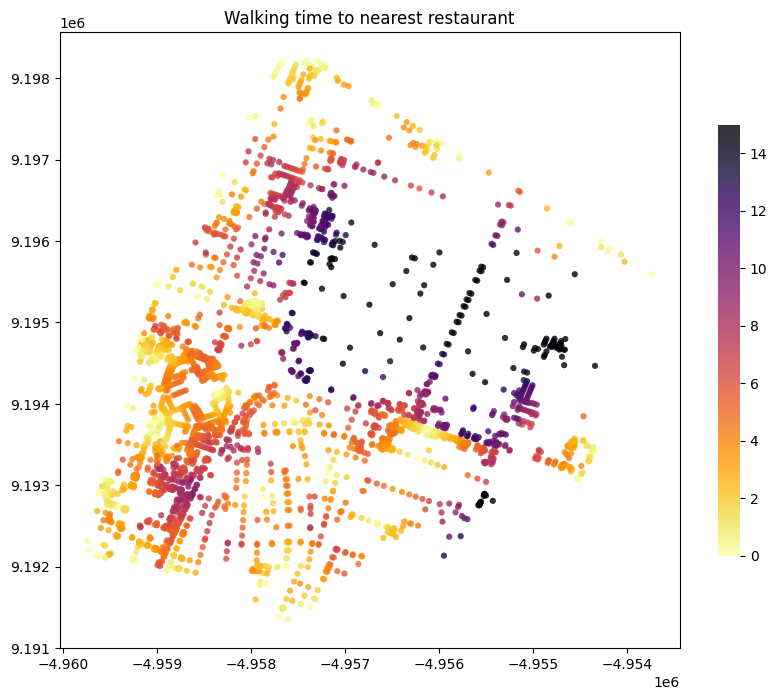

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot distance to nearest amenity from each node
# ox.plot_graph(G_walk_anjou, ax=ax, node_size=0, edge_linewidth=0.1,
#                         edge_color='gray', show=False, close=False)

nodes_anjou = pandana_anjou.nodes_df[['x', 'y']]

sc = ax.scatter(x=nodes_anjou['x'],
                y=nodes_anjou['y'], 
                c=distances_anjou_restaurant['travel_time'], # column to plot (distance to nearest store)
                s=20, # size
                cmap='inferno_r',
                edgecolors='none',
                alpha=0.8)

ax.set_title('Walking time to nearest restaurant')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

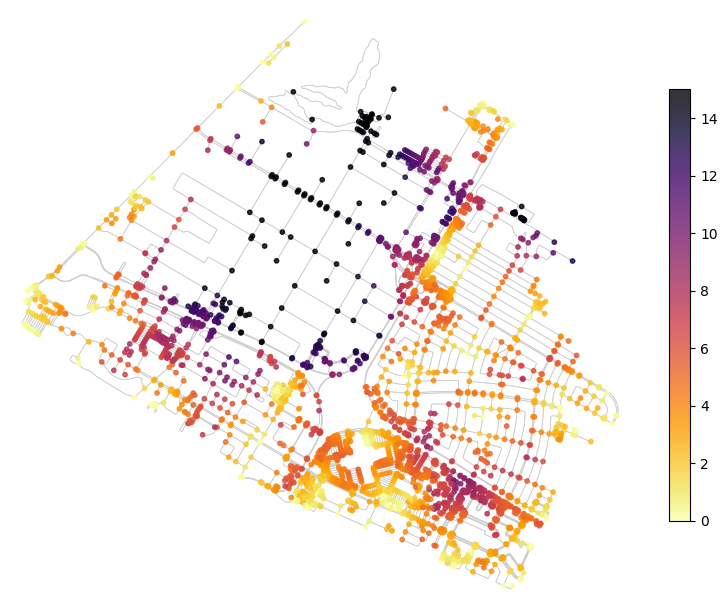

In [35]:
# this graph also has the right celestial projection (north on top)

G = ox.graph_from_place('Anjou, Montreal, Canada', network_type='walk')

# Project the graph to an appropriate CRS
G_proj = ox.project_graph(G)

# Plot the graph with a light background
fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)

# Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)

# Scatter plot on the same Axes instance
sc = ax.scatter(x=nodes_proj['x'], y=nodes_proj['y'], c=distances_anjou_restaurant['travel_time'], s=10, cmap='inferno_r', alpha=0.8)

# Add colorbar
plt.colorbar(sc, ax=ax, shrink=0.7)

# Show the plot
plt.show()

## Following from Michels code

### Walking 

In [75]:
def get_walking_distances(amenity):    
    place = 'Montreal, Canada'
    # Get all the "fresh food" stores on OSM within the study site
    tags = {'amenity': [amenity]}
    amenities = ox.features_from_place(place, tags=tags)
    amenities = amenities.to_crs('EPSG:25832')
    print(amenities)
    # Some amenities might be polygons, but we need them as points, so let's extract the centroids from the amenities' geometries
    centroids = amenities.centroid
    print(centroids)

    # graphs_dir = '/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs'
    graphs_dir = '../graphs'

    walk_graphs = {}
    for file_name in tqdm(os.listdir(graphs_dir)):
        if file_name.endswith(".graphml"):
            neighborhood = file_name.replace("G_walk_", "").replace(".graphml", "")
            file_path = os.path.join(graphs_dir, file_name)
            G_walk_neighborhood = ox.load_graphml(file_path)
            graphs[neighborhood] = G_walk_neighborhood
                
    print(walk_graphs)
    walk_pandanas = {}
    # Build Pandana network for each neighborhood
    for neighborhood, graph in tqdm(graphs.items()):
        graph = ox.project_graph(graph, to_crs='EPSG:25832')
        nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
        edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]
        
        network = pdna.Network(node_x=nodes['x'],
                                node_y=nodes['y'], 
                                edge_from=edges['u'],
                                edge_to=edges['v'],
                                edge_weights=edges[['travel_time']])
        
        pandanas[neighborhood] = network

    print(walk_pandanas)

    walk_time = 15  # max walking horizon in minutes
    walk_speed = 5  # km per hour
    walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx


    walking_distances = {}
    for neighborhood, pandana in tqdm(pandanas.items()):
        pandana.set_pois(category=amenity, # amenity set here
                        maxdist=walk_time_sec,
                        maxitems=3,
                        x_col=centroids.x, 
                        y_col=centroids.y)
        
        distances = pandana.nearest_pois(distance=walk_time_sec,
                                        category=amenity, # amenity set here
                                        num_pois=3)
        
        distances['travel_time'] = distances[1] / 60
        walking_distances[neighborhood] = distances

    print(walking_distances)

    G_walk_anjou = graphs['Anjou, Montreal, Canada'] # access one graph
    pandana_anjou = pandanas['Anjou, Montreal, Canada'] # access one pandana network
    walking_distances_anjou = walking_distances['Anjou, Montreal, Canada']

                                                                   geometry  \
element_type osmid                                                            
node         2323810748                    POINT (-4966584.854 9190467.959)   
             2496131041                    POINT (-4956145.842 9190449.439)   
             3635729635                    POINT (-4968467.877 9193342.471)   
             10792747906                   POINT (-4973909.131 9205851.155)   
             11060200105                   POINT (-4971907.943 9190838.826)   
way          27337520     POLYGON ((-4975816.495 9197673.729, -4975824.2...   
             30176656     POLYGON ((-4974953.009 9193857.845, -4974904.7...   
             38718894     POLYGON ((-4971650.185 9192226.505, -4971634.2...   
             100902617    POLYGON ((-4962250.262 9193133.080, -4962298.9...   
             101122868    POLYGON ((-4961740.798 9193322.779, -4961824.0...   
             102124828    POLYGON ((-4978746.858 919

100%|██████████| 18/18 [00:27<00:00,  1.52s/it]


{}


  6%|▌         | 1/18 [00:02<00:42,  2.50s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 9639
Setting CH edge vector of size 30838
Range graph removed 31100 edges of 61676
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 11%|█         | 2/18 [00:05<00:47,  2.99s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 14281
Setting CH edge vector of size 46136
Range graph removed 46506 edges of 92272
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 17%|█▋        | 3/18 [00:10<00:54,  3.63s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 14970
Setting CH edge vector of size 48624
Range graph removed 48876 edges of 97248
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 22%|██▏       | 4/18 [00:10<00:33,  2.39s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 2588
Setting CH edge vector of size 8290
Range graph removed 8386 edges of 16580
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 28%|██▊       | 5/18 [00:12<00:28,  2.16s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 9720
Setting CH edge vector of size 31244
Range graph removed 31622 edges of 62488
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 33%|███▎      | 6/18 [00:15<00:28,  2.36s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 12319
Setting CH edge vector of size 38440
Range graph removed 38976 edges of 76880
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 39%|███▉      | 7/18 [00:15<00:19,  1.80s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3382
Setting CH edge vector of size 10774
Range graph removed 10912 edges of 21548
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 44%|████▍     | 8/18 [00:16<00:13,  1.39s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3200
Setting CH edge vector of size 9782
Range graph removed 9918 edges of 19564
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 50%|█████     | 9/18 [00:17<00:11,  1.30s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3603
Setting CH edge vector of size 11218
Range graph removed 11360 edges of 22436
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 56%|█████▌    | 10/18 [00:18<00:08,  1.08s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3795
Setting CH edge vector of size 11622
Range graph removed 11734 edges of 23244
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 61%|██████    | 11/18 [00:20<00:11,  1.60s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 10411
Setting CH edge vector of size 33610
Range graph removed 33746 edges of 67220
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 67%|██████▋   | 12/18 [00:23<00:11,  1.85s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 8890
Setting CH edge vector of size 29956
Range graph removed 30224 edges of 59912
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 72%|███████▏  | 13/18 [00:23<00:06,  1.36s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 1552
Setting CH edge vector of size 4430
Range graph removed 4700 edges of 8860
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 78%|███████▊  | 14/18 [00:26<00:07,  1.94s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 13822
Setting CH edge vector of size 43760
Range graph removed 44322 edges of 87520
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 83%|████████▎ | 15/18 [00:27<00:04,  1.52s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3761
Setting CH edge vector of size 11500
Range graph removed 11874 edges of 23000
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 89%|████████▉ | 16/18 [00:31<00:04,  2.24s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 16731
Setting CH edge vector of size 55202
Range graph removed 55584 edges of 110404
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 94%|█████████▍| 17/18 [00:31<00:01,  1.65s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 1441
Setting CH edge vector of size 4694
Range graph removed 4774 edges of 9388
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

100%|██████████| 18/18 [00:33<00:00,  1.85s/it]


Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 6417
Setting CH edge vector of size 20386
Range graph removed 20608 edges of 40772
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
{}


100%|██████████| 18/18 [00:00<00:00, 27.68it/s]

{'Mercier–Hochelaga-Maisonneuve, Montreal, Canada':                  1      2      3  travel_time
osmid                                        
26232893     900.0  900.0  900.0         15.0
11495723273  900.0  900.0  900.0         15.0
11495723274  900.0  900.0  900.0         15.0
11495717756  900.0  900.0  900.0         15.0
30914720     900.0  900.0  900.0         15.0
...            ...    ...    ...          ...
11862799553  900.0  900.0  900.0         15.0
11862799552  900.0  900.0  900.0         15.0
11862799555  900.0  900.0  900.0         15.0
11862799564  900.0  900.0  900.0         15.0
11862799568  900.0  900.0  900.0         15.0

[9639 rows x 4 columns], 'Côte-des-Neiges–Notre-Dame-de-Grâce, Montreal, Canada':                       1           2           3  travel_time
osmid                                                       
29237095     596.200012  671.400024  900.000000     9.936667
10790652823  590.900024  669.900024  900.000000     9.848334
10790652826  601.700012

In [80]:


def get_walking_distances(amenities_list):
    place = 'Montreal, Canada'
    # Get all the specified amenities on OSM within the study site
    walking_distances = {}
    
    for amenity in amenities_list:
        # Get amenities data
        tags = {'amenity': [amenity]}
        amenities = ox.features_from_place(place, tags=tags)
        amenities = amenities.to_crs('EPSG:25832')
        
        # Extract centroids
        centroids = amenities.centroid
        
        # Load graphs
        graphs_dir = '../graphs'
        graphs = {}
        for file_name in tqdm(os.listdir(graphs_dir)):
            if file_name.endswith(".graphml"):
                neighborhood = file_name.replace("G_walk_", "").replace(".graphml", "")
                file_path = os.path.join(graphs_dir, file_name)
                G_walk_neighborhood = ox.load_graphml(file_path)
                graphs[neighborhood] = G_walk_neighborhood
        
        # Build Pandana networks
        pandanas = {}
        for neighborhood, graph in tqdm(graphs.items()):
            graph = ox.project_graph(graph, to_crs='EPSG:25832')
            nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
            edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]
            
            network = pdna.Network(node_x=nodes['x'],
                                   node_y=nodes['y'], 
                                   edge_from=edges['u'],
                                   edge_to=edges['v'],
                                   edge_weights=edges[['travel_time']])
            
            pandanas[neighborhood] = network
        
        # Calculate walking distances
        walk_time = 15  # max walking horizon in minutes
        walk_time_sec = walk_time * 60  # We need the time in seconds to match how travel time is calculated in OSMnx
        
        walking_distances[amenity] = {}
        for neighborhood, pandana in tqdm(pandanas.items()):
            pandana.set_pois(category=amenity,
                              maxdist=walk_time_sec,
                              maxitems=3,
                              x_col=centroids.x, 
                              y_col=centroids.y)
            
            distances = pandana.nearest_pois(distance=walk_time_sec,
                                             category=amenity,
                                             num_pois=3)
            
            distances['travel_time'] = distances[1] / 60
            walking_distances[amenity][neighborhood] = distances
    
    walking_distances_df = {}
    for amenity, distances_dict in walking_distances.items():
        # Create a Series from the distances dictionary
        distances_series = pd.Series(distances_dict)
        # Convert the Series to a DataFrame with a specified index
        walking_distances_df[amenity] = pd.DataFrame({'neighborhood': distances_series.index, 'travel_time': distances_series.values})

    return walking_distances_df


# Example usage:
amenities_list = ['restaurant', 'pharmacy']
walking_distances_df = get_walking_distances(amenities_list)


  6%|▌         | 1/18 [00:02<00:48,  2.84s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 9639
Setting CH edge vector of size 30838
Range graph removed 31100 edges of 61676
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 11%|█         | 2/18 [00:05<00:45,  2.84s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 14281
Setting CH edge vector of size 46136
Range graph removed 46506 edges of 92272
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 17%|█▋        | 3/18 [00:10<00:57,  3.86s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 14970
Setting CH edge vector of size 48624
Range graph removed 48876 edges of 97248
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 22%|██▏       | 4/18 [00:11<00:35,  2.53s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 2588
Setting CH edge vector of size 8290
Range graph removed 8386 edges of 16580
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 28%|██▊       | 5/18 [00:13<00:29,  2.26s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 9720
Setting CH edge vector of size 31244
Range graph removed 31622 edges of 62488
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 33%|███▎      | 6/18 [00:16<00:32,  2.70s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 12319
Setting CH edge vector of size 38440
Range graph removed 38976 edges of 76880
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 39%|███▉      | 7/18 [00:17<00:22,  2.02s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3382
Setting CH edge vector of size 10774
Range graph removed 10912 edges of 21548
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 44%|████▍     | 8/18 [00:17<00:15,  1.53s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3200
Setting CH edge vector of size 9782
Range graph removed 9918 edges of 19564
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 50%|█████     | 9/18 [00:18<00:10,  1.22s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3603
Setting CH edge vector of size 11218
Range graph removed 11360 edges of 22436
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 56%|█████▌    | 10/18 [00:18<00:08,  1.02s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3795
Setting CH edge vector of size 11622
Range graph removed 11734 edges of 23244
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 61%|██████    | 11/18 [00:21<00:09,  1.39s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 10411
Setting CH edge vector of size 33610
Range graph removed 33746 edges of 67220
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 67%|██████▋   | 12/18 [00:25<00:13,  2.18s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 8890
Setting CH edge vector of size 29956
Range graph removed 30224 edges of 59912
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 72%|███████▏  | 13/18 [00:25<00:07,  1.59s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 1552
Setting CH edge vector of size 4430
Range graph removed 4700 edges of 8860
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 78%|███████▊  | 14/18 [00:27<00:07,  1.91s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 13822
Setting CH edge vector of size 43760
Range graph removed 44322 edges of 87520
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 83%|████████▎ | 15/18 [00:28<00:04,  1.51s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3761
Setting CH edge vector of size 11500
Range graph removed 11874 edges of 23000
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 89%|████████▉ | 16/18 [00:33<00:04,  2.46s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 16731
Setting CH edge vector of size 55202
Range graph removed 55584 edges of 110404
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 94%|█████████▍| 17/18 [00:33<00:01,  1.80s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 1441
Setting CH edge vector of size 4694
Range graph removed 4774 edges of 9388
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

100%|██████████| 18/18 [00:34<00:00,  1.92s/it]


Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 6417
Setting CH edge vector of size 20386
Range graph removed 20608 edges of 40772
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


  6%|▌         | 1/18 [00:02<00:35,  2.09s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 9639
Setting CH edge vector of size 30838
Range graph removed 31100 edges of 61676
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 11%|█         | 2/18 [00:06<00:55,  3.48s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 14281
Setting CH edge vector of size 46136
Range graph removed 46506 edges of 92272
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 17%|█▋        | 3/18 [00:10<00:53,  3.57s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 14970
Setting CH edge vector of size 48624
Range graph removed 48876 edges of 97248
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 22%|██▏       | 4/18 [00:12<00:42,  3.03s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 2588
Setting CH edge vector of size 8290
Range graph removed 8386 edges of 16580
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 28%|██▊       | 5/18 [00:14<00:33,  2.56s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 9720
Setting CH edge vector of size 31244
Range graph removed 31622 edges of 62488
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 33%|███▎      | 6/18 [00:16<00:28,  2.40s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 12319
Setting CH edge vector of size 38440
Range graph removed 38976 edges of 76880
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 39%|███▉      | 7/18 [00:16<00:19,  1.81s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3382
Setting CH edge vector of size 10774
Range graph removed 10912 edges of 21548
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 44%|████▍     | 8/18 [00:18<00:18,  1.82s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3200
Setting CH edge vector of size 9782
Range graph removed 9918 edges of 19564
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 50%|█████     | 9/18 [00:19<00:12,  1.43s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3603
Setting CH edge vector of size 11218
Range graph removed 11360 edges of 22436
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 56%|█████▌    | 10/18 [00:19<00:09,  1.16s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3795
Setting CH edge vector of size 11622
Range graph removed 11734 edges of 23244
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 61%|██████    | 11/18 [00:21<00:10,  1.48s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 10411
Setting CH edge vector of size 33610
Range graph removed 33746 edges of 67220
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 67%|██████▋   | 12/18 [00:25<00:13,  2.21s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 8890
Setting CH edge vector of size 29956
Range graph removed 30224 edges of 59912
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 72%|███████▏  | 13/18 [00:26<00:08,  1.61s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 1552
Setting CH edge vector of size 4430
Range graph removed 4700 edges of 8860
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 78%|███████▊  | 14/18 [00:28<00:07,  1.97s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 13822
Setting CH edge vector of size 43760
Range graph removed 44322 edges of 87520
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 83%|████████▎ | 15/18 [00:29<00:04,  1.54s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3761
Setting CH edge vector of size 11500
Range graph removed 11874 edges of 23000
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 89%|████████▉ | 16/18 [00:34<00:05,  2.60s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 16731
Setting CH edge vector of size 55202
Range graph removed 55584 edges of 110404
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 94%|█████████▍| 17/18 [00:34<00:01,  1.90s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 1441
Setting CH edge vector of size 4694
Range graph removed 4774 edges of 9388
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

100%|██████████| 18/18 [00:35<00:00,  2.00s/it]


Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 6417
Setting CH edge vector of size 20386
Range graph removed 20608 edges of 40772
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


100%|██████████| 18/18 [00:00<00:00, 25.70it/s]


In [103]:
# reindex dataframe with neighborhood names as index for each amenity
all_distances_walk = pd.concat([df.assign(neighborhood=name) for name, df in walking_distances.items()], ignore_index=True)
all_distances_walk = all_distances_walk.sort_values(by='travel_time')

In [91]:
walking_distances_df['pharmacy']['travel_time'][0]

,1,2,3,travel_time
osmid,,,,
26232893,703.400024,703.400024,732.500000,11.723334
11495723273,714.299988,714.299988,743.400024,11.905000
11495723274,696.200012,696.200012,725.299988,11.603334
11495717756,733.099976,733.099976,762.200012,12.218333
30914720,566.700012,900.000000,900.000000,9.445000
...,...,...,...,...
11862799553,900.000000,900.000000,900.000000,15.000000
11862799552,900.000000,900.000000,900.000000,15.000000
11862799555,900.000000,900.000000,900.000000,15.000000


In [92]:
walking_distances_df['restaurant']['travel_time'][0]

,1,2,3,travel_time
osmid,,,,
26232893,514.799988,703.400024,703.400024,8.580000
11495723273,525.700012,705.200012,714.299988,8.761667
11495723274,507.600006,696.200012,696.200012,8.460000
11495717756,544.500000,733.099976,733.099976,9.075000
30914720,292.799988,307.100006,451.899994,4.880000
...,...,...,...,...
11862799553,821.299988,900.000000,900.000000,13.688333
11862799552,834.900024,900.000000,900.000000,13.915000
11862799555,834.099976,900.000000,900.000000,13.901666


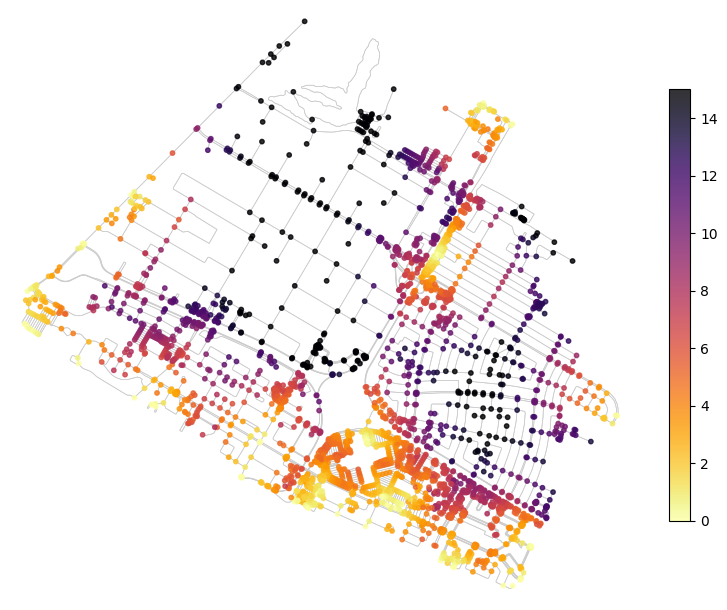

In [69]:
# test with restaurant graph to compare

# this graph also has the right celestial projection (north on top)

G = ox.graph_from_place('Anjou, Montreal, Canada', network_type='walk')

# Project the graph to an appropriate CRS
G_proj = ox.project_graph(G)

# Plot the graph with a light background
fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)

# Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)

# Scatter plot on the same Axes instance
sc = ax.scatter(x=nodes_proj['x'], y=nodes_proj['y'], c=walking_distances_df['travel_time'], s=10, cmap='inferno_r', alpha=0.8)

# Add colorbar
plt.colorbar(sc, ax=ax, shrink=0.7)

# Show the plot
plt.show()

ValueError: setting an array element with a sequence.

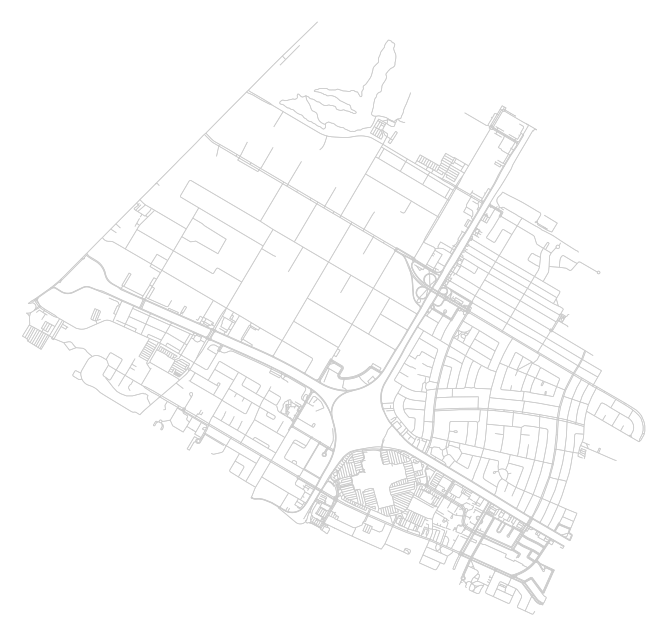

In [100]:
# test with school to see if there is a difference 

# Filter the DataFrame based on the 'neighborhood' column
filtered_df = walking_distances_df[amenity][walking_distances_df[amenity]['neighborhood'] == neighborhood]
# Access the 'travel_time' column of the filtered DataFrame



# this graph also has the right celestial projection (north on top)

G = ox.graph_from_place('Anjou, Montreal, Canada', network_type='walk')

# Project the graph to an appropriate CRS
G_proj = ox.project_graph(G)

# Plot the graph with a light background
fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)

# Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)

# Scatter plot on the same Axes instance
sc = ax.scatter(x=nodes_proj['x'], y=nodes_proj['y'], c=filtered_distances['travel_time'], s=10, cmap='inferno_r', alpha=0.8)

# Add colorbar
plt.colorbar(sc, ax=ax, shrink=0.7)

# Show the plot
plt.show()

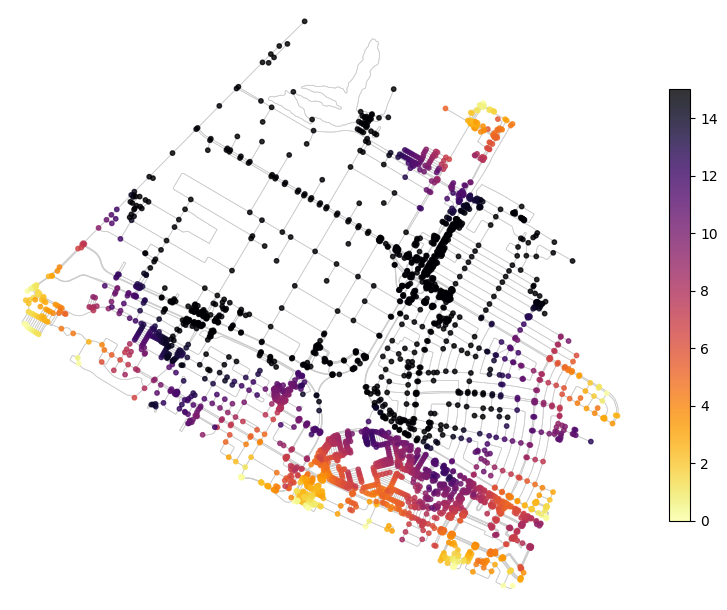

In [73]:
# test with restaurant graph to compare

# this graph also has the right celestial projection (north on top)

G = ox.graph_from_place('Anjou, Montreal, Canada', network_type='walk')

# Project the graph to an appropriate CRS
G_proj = ox.project_graph(G)

# Plot the graph with a light background
fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)

# Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)

# Scatter plot on the same Axes instance
sc = ax.scatter(x=nodes_proj['x'], y=nodes_proj['y'], c=walking_distances_anjou['travel_time'], s=10, cmap='inferno_r', alpha=0.8)

# Add colorbar
plt.colorbar(sc, ax=ax, shrink=0.7)

# Show the plot
plt.show()

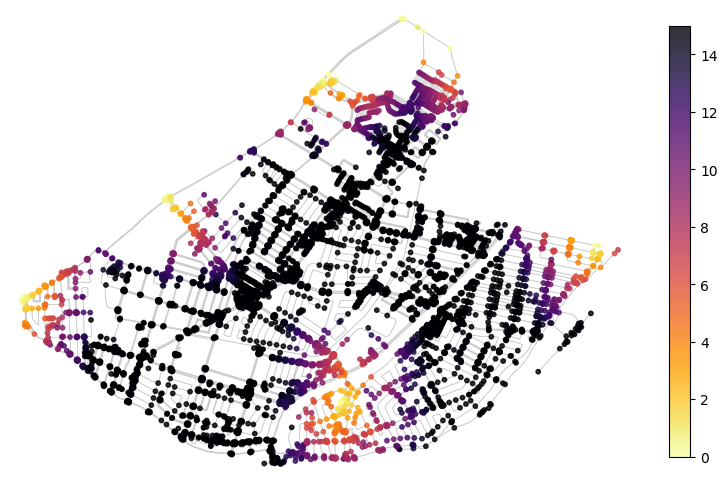

In [77]:


# test with restaurant graph to compare

# this graph also has the right celestial projection (north on top)

G = ox.graph_from_place('LaSalle, Montreal, Canada', network_type='walk')

# Project the graph to an appropriate CRS
G_proj = ox.project_graph(G)

# Plot the graph with a light background
fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)

# Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)

# Scatter plot on the same Axes instance
sc = ax.scatter(x=nodes_proj['x'], y=nodes_proj['y'], c=walking_distances['LaSalle, Montreal, Canada']['travel_time'], s=10, cmap='inferno_r', alpha=0.8)

# Add colorbar
plt.colorbar(sc, ax=ax, shrink=0.7)

# Show the plot
plt.show()

### Biking

In [ ]:
# STILL NEED TO CHANGE THE TIMES DOWN HERE
bike_graphs = {}
for file_name in tqdm(os.listdir(graphs_dir)):
    if file_name.endswith(".graphml"):
        neighborhood = file_name.replace("G_bike_", "").replace(".graphml", "")
        file_path = os.path.join(graphs_dir, file_name)
        G_bike_neighborhood = ox.load_graphml(file_path)
        graphs[neighborhood] = G_bike_neighborhood
            

bike_pandanas = {}
# Build Pandana network for each neighborhood
for neighborhood, graph in tqdm(graphs.items()):
    graph = ox.project_graph(graph, to_crs='EPSG:25832')
    nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
    edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

    network = pdna.Network(node_x=nodes['x'],
                            node_y=nodes['y'], 
                            edge_from=edges['u'],
                            edge_to=edges['v'],
                            edge_weights=edges[['travel_time']])
    
    pandanas[neighborhood] = network

# CHANGE THE TIMES HERE

bike_time = 15  # max biking horizon in minutes
bike_speed = 5  # km per hour
bike_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx


biking_distances = {}
for neighborhood, pandana in tqdm(pandanas.items()):
    pandana.set_pois(category='restaurant', # amenity set here
                    maxdist=bike_time_sec,
                    maxitems=3,
                    x_col=centroids.x, 
                    y_col=centroids.y)
    
    distances = pandana.nearest_pois(distance=bike_time_sec,
                                    category='restaurant', # amenity set here
                                    num_pois=3)
    
    distances['travel_time'] = distances[1] / 60
    biking_distances[neighborhood] = distances
        
# G_walk_anjou = graphs['Anjou, Montreal, Canada'] # access one graph
# pandana_anjou = pandanas['Anjou, Montreal, Canada'] # access one pandana network
biking_distances_anjou = biking_distances['Anjou, Montreal, Canada']

### Driving

In [60]:
# function for plotting
def plot_neighborhood_graph(mode_of_transportation_graph, mode_of_transportation_distances, neighbourhood):
    # Load the graph from the specified place and network type
    G = mode_of_transportation_graph
    # CRS
    G_proj = ox.project_graph(G)
    
    distances = mode_of_transportation_distances[f"{neighbourhood}, Montreal, Canada"]
    
    # Plot the graph with a light background
    fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)
    
    # Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
    nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
    
    # Scatter plot on the same Axes instance
    sc = ax.scatter(x=nodes_proj["x"], y=nodes_proj["y"], c=distances['travel_time'], s=50, cmap='inferno_r', alpha=0.8)
    
    # Add colorbar
    plt.colorbar(sc, ax=ax, shrink=0.7)
    
    # Show the plot
    plt.show()



In [65]:
# example usage
plot_neighborhood_graph(G_walk_anjou, walking_distances_anjou, 'Anjou')

KeyError: 'Anjou, Montreal, Canada'